In [ ]:
#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.
#
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.
#
#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <https://www.gnu.org/licenses/>.

#     Written by Charalambos (Charis) Poullis - www.poullis.org

In [1]:
#import the necessary modules
import torchvision
import sys
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from matplotlib.ticker import MultipleLocator as ML
from matplotlib.ticker import ScalarFormatter as SF

In [2]:
#Set the path for the datasets
DATASET_PATH = "../data"

#Download the dataset: CIFAR10
training_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH,
                                                train=True,
                                                download=True,
                                                transform=torchvision.transforms.ToTensor())
print('Training dataset:', training_dataset)
testing_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH,
                                               train=False,
                                               download=True,
                                               transform=torchvision.transforms.ToTensor())
print('Testing dataset:', testing_dataset)  
labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Files already downloaded and verified
Testing dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
#This function takes a CIFAR dataset and splits it into two numpy arrays containing
#the images and labels, respectively

def splitDataset(dataset):
    #Divide the datasets into images and labels
    x, y = dataset[0]
    
    shape = [(i, *j) for i, j in [(len(dataset), x.shape)]][0]
    images = np.zeros(shape)
    labels = np.zeros((len(dataset), 1))
    
    for i in range(len(dataset)):
        x,y = dataset[i]
        images[i] = x
        labels[i] = y
        
    images = np.reshape(images, (len(dataset),-1))
    labels = np.reshape(labels, (len(dataset),-1))
    return images, labels

In [4]:
#Divide the training datasets into images and labels
training_images, training_labels = splitDataset(training_dataset)
#Do the same for the testing dataset
testing_images, testing_labels = splitDataset(testing_dataset)   

print(f'Training images: {len(training_images)}, Training labels: {len(training_labels)}')
print(f'Testing images: {len(testing_images)}, Testing labels: {len(testing_labels)}')

Training images: 50000, Training labels: 50000
Testing images: 10000, Testing labels: 10000


In [5]:
class MyNN:
    def __init__(self):
        self.X_train = np.zeros((0, 3072))
        self.Y_train = np.zeros((0, 1))
        return

    def eraseTrainingData(self):
        self.X_train = np.zeros((0, 3072))
        self.Y_train = np.array((0, 1))
        return
    
    def train(self, X_train, Y_train):
        self.X_train = np.append(self.X_train, X_train, axis=0)
        self.Y_train = np.append(self.Y_train, Y_train)
        return

    def test(self, X_test, Y_test_gt, number_of_NNs):
        correct_predictions = 0
        
        #Allocate the right size
        Y_test = np.zeros((Y_test_gt.shape[0], number_of_NNs))
        Y_test_NN_indices = np.zeros((Y_test_gt.shape[0], number_of_NNs))

        for i in range(0, len(X_test)):
            #We define the similarity as the sum of the absolute differences
            similarities = np.sum(np.abs(X_test[i,:] - self.X_train), axis=1)
            #Get number_of_NNs smallest similarities
            nearest_neighbours_indices = np.argsort(similarities)[:number_of_NNs]
            #Copy the indices
            Y_test_NN_indices[i] = nearest_neighbours_indices
            #Copy the labels from the nearest neighbours
            Y_test[i] = self.Y_train[nearest_neighbours_indices].reshape(-1)
                   
            #calculate how many are correct; take the majority vote of labels from nearest neighbours
            c = Counter(Y_test[i].tolist())
            predicted_label, votes = c.most_common()[0]
            if predicted_label == Y_test_gt[i]:
                correct_predictions += 1
                
        return correct_predictions, Y_test, Y_test_NN_indices

In [6]:
#Create an instance of the model
model = MyNN()

#Predict the labels for the test images
NUMBER_OF_FOLDS = 5
NUMBER_OF_SAMPLES = 10
NUMBER_OF_K = 50
# training_images = training_images[:100]
number_of_images_per_fold = int(len(training_images)/NUMBER_OF_FOLDS)
print(f'Number of image per fold: {number_of_images_per_fold}')
validation_fold = NUMBER_OF_FOLDS-1
training_fold = 0
accuracies = list()
for k in tqdm(range(1, NUMBER_OF_K), ncols=100, ascii=True, desc="k values processed"):
    accuracy_per_fold = list()

    #Store the training data from the folds
    for i in range(0, NUMBER_OF_FOLDS):
        if i == validation_fold:
            continue
        else:
            #Store the other training fold
            model.train(training_images[i*number_of_images_per_fold: (i+1)*number_of_images_per_fold-1],
                        training_labels[i*number_of_images_per_fold: (i+1)*number_of_images_per_fold-1])
            #Test on the validation test
            random_indices = [random.randint(validation_fold*number_of_images_per_fold, (validation_fold+1)*number_of_images_per_fold-1) for n in range(NUMBER_OF_SAMPLES)]
            correct_predictions, predicted_labels, nearest_neighbours_indices = model.test(training_images[random_indices], 
                                                                                           training_labels[random_indices], k)
            accuracy_per_fold.append(correct_predictions/NUMBER_OF_SAMPLES)
            # print(f"{k}: fold {i} --> {sum(accuracy_per_test)/len(accuracy_per_test)}")
            #Remove all the folds in memory
            model.eraseTrainingData()

    validation_fold = (validation_fold + 1)%NUMBER_OF_FOLDS
    accuracies.append(accuracy_per_fold)
    

Number of image per fold: 10000


k values processed: 100%|###########################################| 49/49 [03:16<00:00,  4.00s/it]


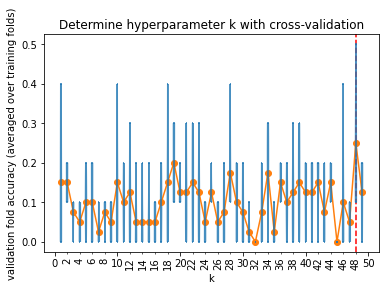

In [7]:
k = np.array(list(range(1, NUMBER_OF_K)))
average_accuracies = np.array([np.average(x) for x in accuracies])

fig, ax = plt.subplots()
ax.set_title("Determine hyperparameter k with cross-validation")
#ax.set(xlim=(0, NUMBER_OF_K), xticks=np.arange(0, NUMBER_OF_K),
#       ylim=(0, 0.5), yticks=np.arange(0, 0.5, 0.05))
ax.xaxis.set_minor_locator(ML(2))
ax.xaxis.set_minor_formatter(SF())
ax.tick_params(axis='x', which='minor', rotation=90)
ax.set_xlabel("k")
ax.set_ylabel("validation fold accuracy (averaged over training folds)")
#add vertical line at the best accuracy
best_k = np.argmax(average_accuracies)
ax.axvline(x=k[best_k], color='red', linestyle='--')

ax.plot(k, average_accuracies, "C1o-")
ax.violinplot(accuracies)

plt.show()
fig.savefig('cross_validation_knn.png', dpi=300)